<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/LinearRegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    print(mean_beta_post)

    # Posterior log-probability
    posterior_beta = pm.MvNormal('posterior_beta', mu=mean_beta_post, cov=cov_beta_post)
    posterior_pd = pm.Deterministic("posterior_pd", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_beta), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())

    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_pd - prior_pd)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [ 2.02285181  3.72778458 -0.090022    0.80840662 -0.8493315   4.81056796
 -3.30669514 -0.59163993 -2.15400519 -1.01798558 -1.9658222  -3.54945497
  2.09785444  1.25024263 -1.13535921 -0.4309976   0.52444264  4.91380017
  2.14464964 -1.80711183]
[[ 0.06352878 -0.02965681]
 [-0.02965681  0.07935113]]
[1.09114098 1.74170568]


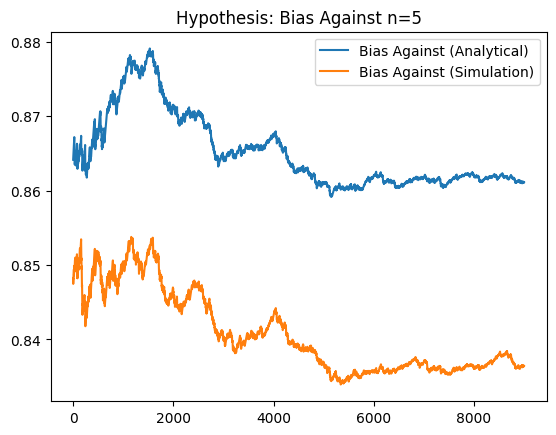

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

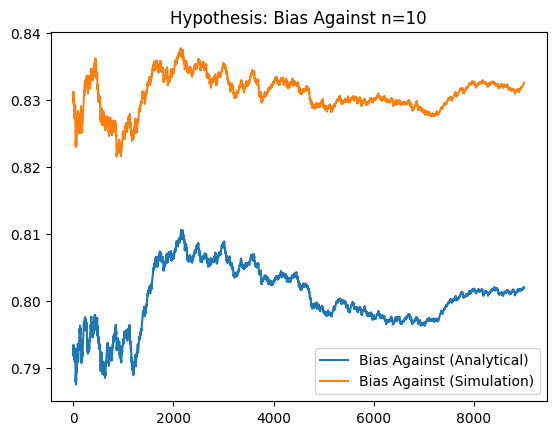

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

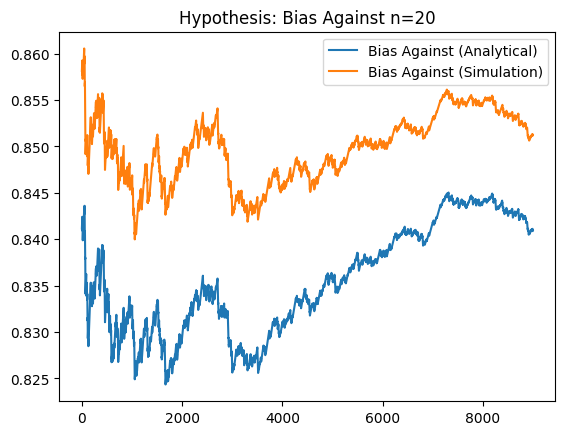

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

Regular Upper Lower (Same delta for both)

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
delta = 0.05
sigma0 = 1
betal = beta0 - delta
print(betal)
betau = beta0 + delta
print(betau)

mu0 = np.dot(X, beta0)
mul = np.dot(X, betal)
muu = np.dot(X, betau)

# Generate response variable y
yl = mul + np.random.normal(0, sigma0, n)
yu = muu + np.random.normal(0, sigma0, n)


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_l = pm.MvNormal('y_l', mu=mul, cov= (sigma0**2)*np.eye(n), shape = n)
    y_u = pm.MvNormal('y_u', mu=muu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_postl = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    mean_beta_postu = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yu)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

    # Posterior log-probability
    posterior_betal = pm.MvNormal('posterior_betal', mu=mean_beta_postl, cov=cov_beta_post)
    posterior_betau = pm.MvNormal('posterior_betau', mu=mean_beta_postu, cov=cov_beta_post)

    posterior_pdl = pm.Deterministic("posterior_pdl", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0).sum())
    posterior_pdu = pm.Deterministic("posterior_pdu", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betau), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0).sum())

    # Log BR
    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_pdu - prior_pd)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic("likelihood_prior_pdl", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_l).sum())
    likelihood_prior_pdu = pm.Deterministic("likelihood_prior_pdu", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_u).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

[0.95 1.95]
[1.05 2.05]
[[0.02868068 0.00318908]
 [0.00318908 0.05387043]]


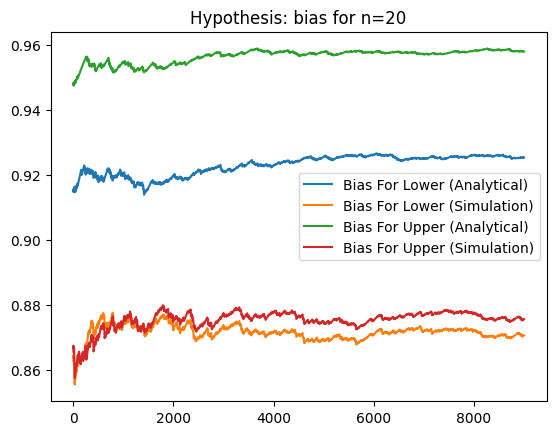

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
xl_samples = idata.posterior['y_l'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['y_u'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Delta values around the circle:

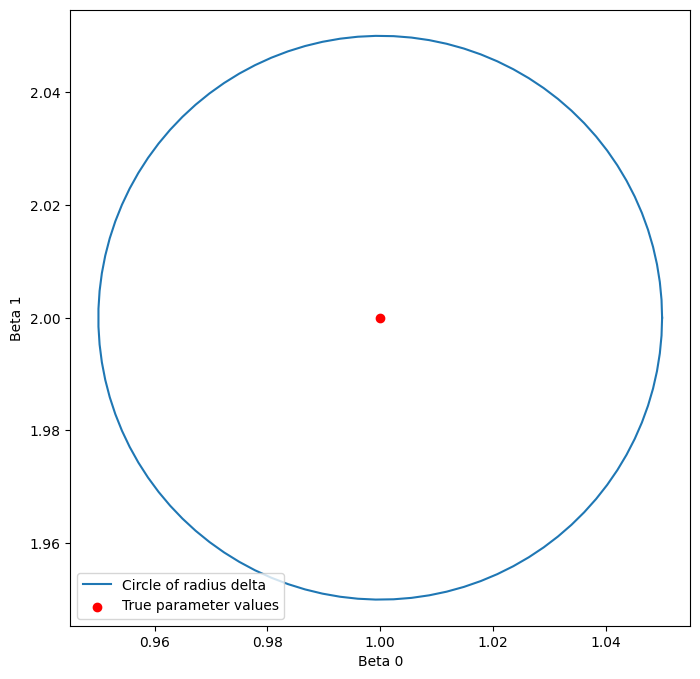

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Radius of the circle

# Generate points on the circle
num_points = 100  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')
plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc = 3)
plt.axis('equal')
plt.show()

# Print the points on the circle
circle_points = np.column_stack((x, y))


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (404), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/

                            mean         sd   hdi_3%  hdi_97%  mcse_mean  \
beta[0]                   -0.003      1.021   -1.917    1.918      0.008   
beta[1]                    0.009      0.979   -1.752    1.934      0.008   
posterior_beta_0[0]        1.294      0.224    0.858    1.699      0.002   
posterior_beta_0[1]        2.179      0.178    1.847    2.510      0.001   
posterior_beta_1[0]        0.944      0.227    0.542    1.398      0.002   
...                          ...        ...      ...      ...        ...   
logBR_prior_pd_98        -70.432     72.839 -205.744   66.976      0.573   
likelihood_prior_pd_98 -2691.352  73604.452 -334.772  -31.298    966.497   
posterior_pd_99          -98.806     71.059 -226.458    1.361      0.678   
logBR_prior_pd_99        -55.801     66.206 -181.699   65.932      0.521   
likelihood_prior_pd_99 -2149.392  58683.654 -264.028  -29.032    770.572   

                        mcse_sd  ess_bulk  ess_tail  r_hat  
beta[0]                   

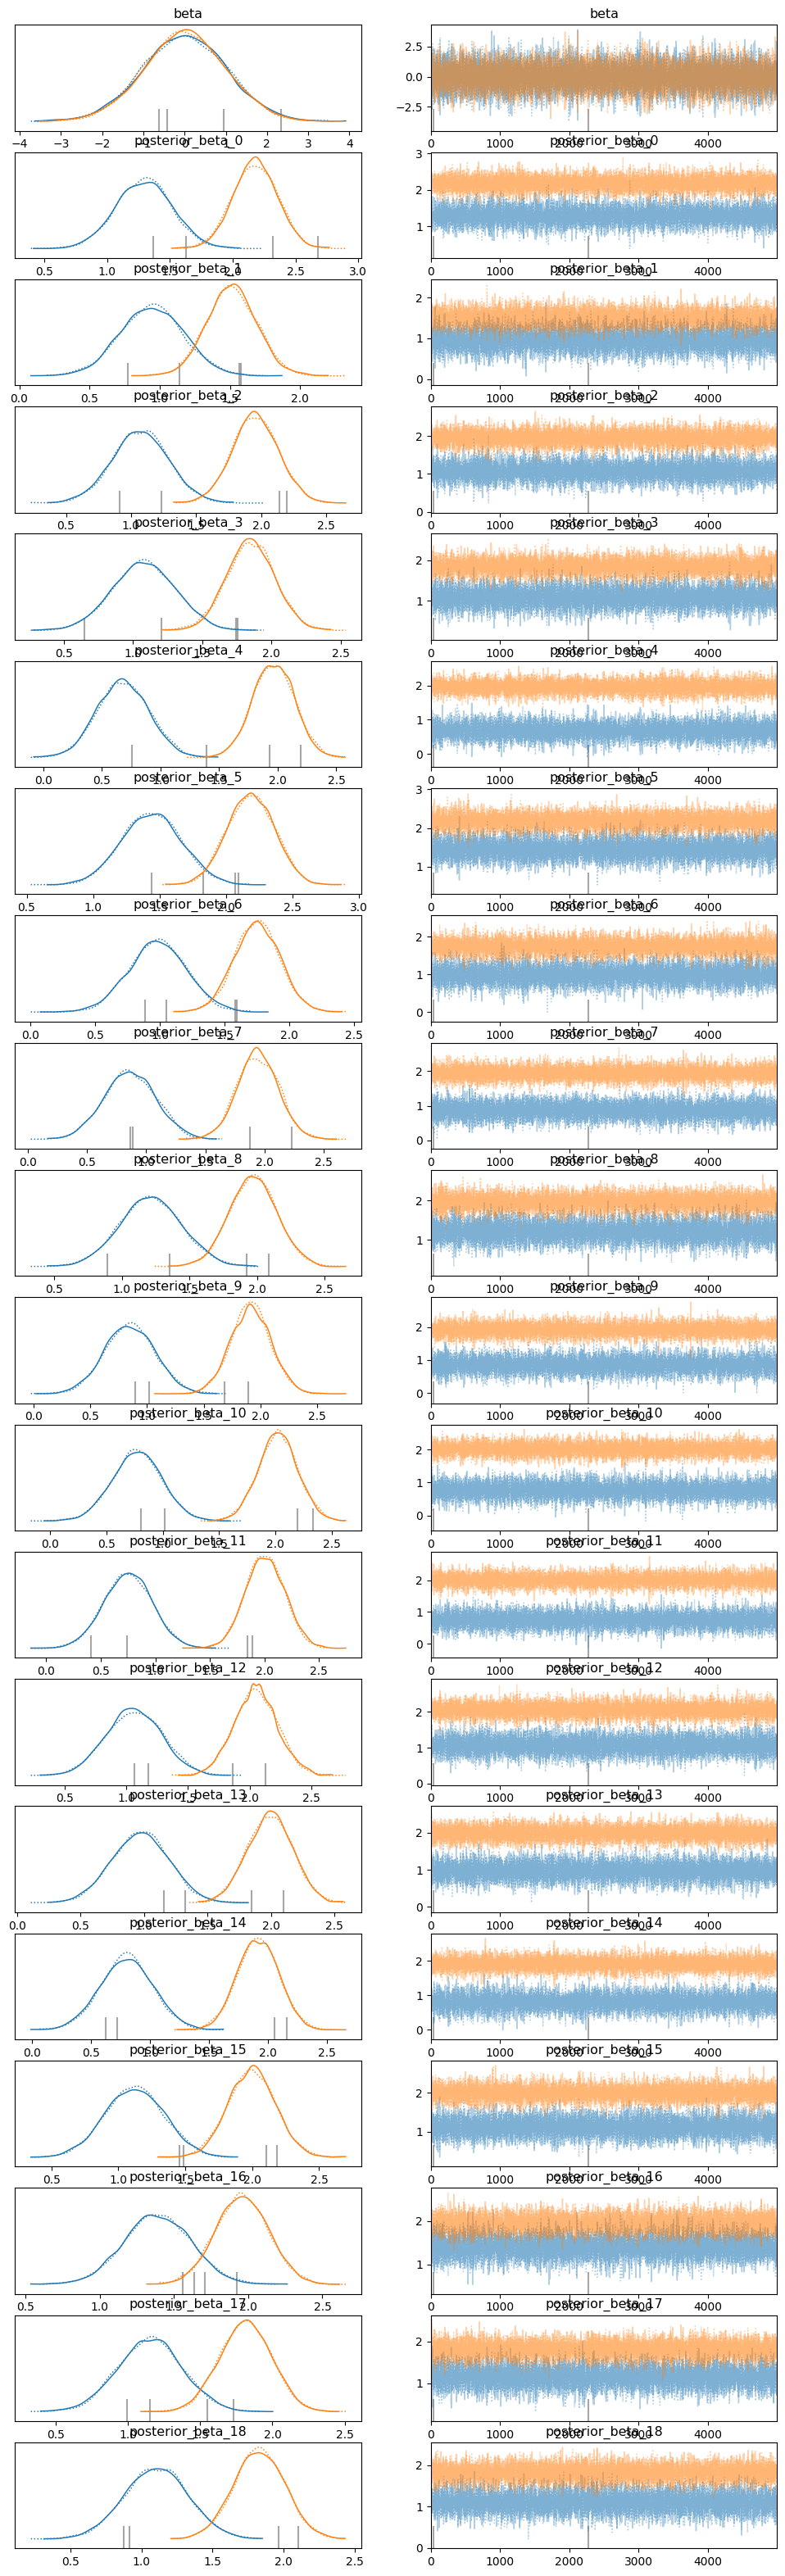

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
delta = 0.05
sigma0 = 1

# Generate points on the circle around beta0
num_points = 100  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
beta_circle = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

# Generate response variables for each point on the circle
y_circle = []
for beta in beta_circle:
    mu = np.dot(X, beta)
    y = mu + np.random.normal(0, sigma0, n)
    y_circle.append(y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    posterior_pds = []
    logBR_prior_pds = []
    likelihood_prior_pds = []

    # Iterate over each point on the circle
    for idx, (mu_i, y_i) in enumerate(zip(beta_circle, y_circle)):
        # Posterior mean and covariance for beta
        mul = np.dot(X, mu_i)
        X_transpose = X.T
        Sigma_inv = np.eye(n) / sigma0**2
        Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

        cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y_i)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_beta = pm.MvNormal(f'posterior_beta_{idx}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pd = pm.Deterministic(f"posterior_pd_{idx}", pm.logp(posterior_beta, beta).sum())
        posterior_pds.append(posterior_pd)

        # Log BR
        logBR_prior_pd = pm.Deterministic(f"logBR_prior_pd_{idx}", posterior_pd - prior_pd)
        logBR_prior_pds.append(logBR_prior_pd)

        # Likelihood
        likelihood_prior_pd = pm.Deterministic(f"likelihood_prior_pd_{idx}", pm.logp(pm.MvNormal.dist(mu=mul, cov=(sigma**2)*np.eye(n), shape=(n,)), y_i).sum())
        likelihood_prior_pds.append(likelihood_prior_pd)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

# Print summary and plot
az.plot_trace(idata)
print(az.summary(idata))


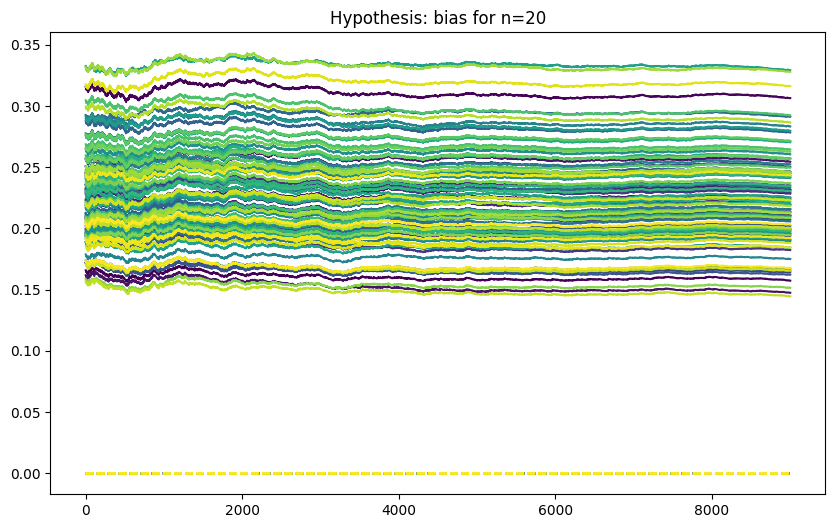

In [73]:
from matplotlib import cm

# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000

for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pd_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pd_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'posterior_beta_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis: bias for n={}".format(n))
plt.show()